In [1]:
import time
import string
import random
from itertools import permutations
from collections import defaultdict

import requests
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt


plt.style.use('blackontrans')

In [2]:
class CipherCorpus():
    def __init__(self, corpus_text, allowed_chars=None):
        self.corpus_text = corpus_text
        self.allowed_chars = allowed_chars
        if self.allowed_chars is None:
            self.allowed_chars = string.ascii_lowercase + ' '
        
        clean_corpus_text = self.clean_text(corpus_text)
        self.transition_freqs = self.create_transition_freqs(clean_corpus_text)

    def clean_text(self, text):
        text = text.lower()
        text = text.replace('\n', ' ')
        remove_chars = set(text) - set(self.allowed_chars)
        for char in remove_chars:
            text = text.replace(char, '')
        return text

    def make_mapping(self, scrambled_chars=None):
        if scrambled_chars is None:
            scrambled_chars = random.sample(self.allowed_chars, len(self.allowed_chars))
        return str.maketrans({char0: char1 for char0, char1 in zip(self.allowed_chars, scrambled_chars)})

    def scramble_text(self, text):
        clean_text = self.clean_text(text)
        mapping = self.make_mapping()
        return clean_text.translate(mapping)

    @property
    def available_swaps(self):
        return list(permutations(self.make_mapping(), 2))

    @staticmethod
    def create_transition_freqs(text):
        transition_counts = defaultdict(int)
        n_transitions = len(text) - 1

        for char0, char1 in zip(text[:-1], text[1:]):
            transition_counts[(char0, char1)] += 1

        # Set the default for any missing transitions to pretend we found just 1
        transition_freqs = defaultdict(lambda: np.log(1 / n_transitions))
        for key, val in transition_counts.items():
            transition_freqs[key] = np.log(val / n_transitions)

        return transition_freqs


class CipherScorer():
    def __init__(self, transition_freqs, test_text):
        self.transition_freqs = transition_freqs
        self.test_text = test_text
        self._score_cache = {}
        self.cache_hits = 0

    def _score(self, mapping):
        candidate_text = self.test_text.translate(mapping)
        return sum(self.transition_freqs[tup] for tup in zip(candidate_text[:-1], candidate_text[1:]))

    def score(self, mapping):
        cache_key = tuple(mapping.values())
        try:
            score = self._score_cache[cache_key]
            self.cache_hits += 1
        except KeyError:
            score = self._score(mapping)
            self._score_cache[cache_key] = score
        return score

    def reset(self):
        self._score_cache = {}
        self.cache_hits = 0


def solve(cipher_scorer, init_mapping, available_swaps, step_rule, timeout=np.inf):
    end_time = time.time() + timeout
    curr_mapping = init_mapping
    curr_score = cipher_scorer.score(curr_mapping)
    search_history = [(curr_score, curr_mapping)]
    while time.time() < end_time:
        random.shuffle(available_swaps)
        for char0, char1 in available_swaps:
            swap_keys(curr_mapping, char0, char1)  # mutate to candidate with a swap
            candidate_score = cipher_scorer.score(curr_mapping)
            if step_rule(curr_score, candidate_score):
                break  # step accepted, so break the for loop, i.e. move to that step
            swap_keys(curr_mapping, char1, char0)  # swap back
        else:
            break  # no steps accepted, so break while loop, i.e. we've converged
        curr_score = candidate_score
        search_history.append((curr_score, curr_mapping))
    return search_history    
    

def swap_keys(dictionary, key0, key1):
    dictionary[key0], dictionary[key1] = dictionary[key1], dictionary[key0]

    
def simple_step_rule(curr_score, candidate_score):
    return candidate_score > curr_score


def probabilistic_step_rule(curr_score, candidate_score):
    return random.random() < np.exp(candidate_score - curr_score)

In [3]:
def get_war_and_peace():
    url = 'https://raw.githubusercontent.com/fluentpython/example-code/master/attic/sequences/war-and-peace.txt'
    response = requests.get(url)
    text = response.content.decode('utf-8')
    start_str = '*** START OF THIS PROJECT GUTENBERG EBOOK WAR AND PEACE ***'
    end_str = '*** END OF THIS PROJECT GUTENBERG EBOOK WAR AND PEACE ***'
    war_and_peace = text.split(start_str)[1].split(end_str)[0]
    return war_and_peace


war_and_peace = get_war_and_peace()

In [4]:
cipher_corpus = CipherCorpus(war_and_peace)

test_text = """
She should have died hereafter;
There would have been a time for such a word.
— To-morrow, and to-morrow, and to-morrow,
Creeps in this petty pace from day to day,
To the last syllable of recorded time;
And all our yesterdays have lighted fools
The way to dusty death.
Out, out, brief candle!
Life is but a walking shadow, a poor player
That struts and frets his hour upon the stage
And then is heard no more. It is a tale
Told by an idiot, full of sound and fury
Signifying nothing.
"""
clean_test_text = cipher_corpus.clean_text(test_text)

In [5]:
runs = 1000
time_step_size = 0.05
time_limit = 60
rows = []

for _ in range(runs):
    row = {}
    scrambled_text = cipher_corpus.scramble_text(clean_test_text)

    cipher_scorer = CipherScorer(cipher_corpus.transition_freqs, scrambled_text)
    runs = 1
    start_time = time.time()
    while True:
        search_history = solve(cipher_scorer, cipher_corpus.make_mapping(), cipher_corpus.available_swaps, simple_step_rule)
        best_mapping = search_history[-1][1]
        best_guess = scrambled_text.translate(best_mapping)
        if best_guess == clean_test_text:
            break
        runs += 1
    duration = time.time() - start_time

    row['opt_runs'] = runs
    row['opt_duration'] = duration
    row['opt_evals'] = cipher_scorer.cache_hits + len(cipher_scorer._score_cache)
    row['opt_unique_evals'] = len(cipher_scorer._score_cache)

    cipher_scorer.reset()
    duration = 0
    curr_mapping = cipher_corpus.make_mapping()
    while duration < time_limit:
        duration += time_step_size
        search_history = solve(cipher_scorer, curr_mapping, cipher_corpus.available_swaps, probabilistic_step_rule, time_step_size)
        best_mapping = sorted(search_history, key=lambda x: x[0])[-1][1]
        best_guess = scrambled_text.translate(best_mapping)
        success = best_guess == clean_test_text
        if success:
            break
        curr_mapping = search_history[-1][1]
    row['MCMC_success'] = success
    row['MCMC_duration'] = duration if success else np.nan
    row['MCMC_evals'] = cipher_scorer.cache_hits + len(cipher_scorer._score_cache)
    row['MCMC_unique_evals'] = len(cipher_scorer._score_cache)

    rows.append(row)

results = pd.DataFrame(rows)
results.mean()

/home/matt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:104: RuntimeWarning: overflow encountered in exp


opt_runs                  1.612000
opt_duration              0.305226
opt_evals              4521.447000
opt_unique_evals       3570.652000
MCMC_success              0.945000
MCMC_duration             2.010794
MCMC_evals           410829.418000
MCMC_unique_evals     22268.690000
dtype: float64

findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.


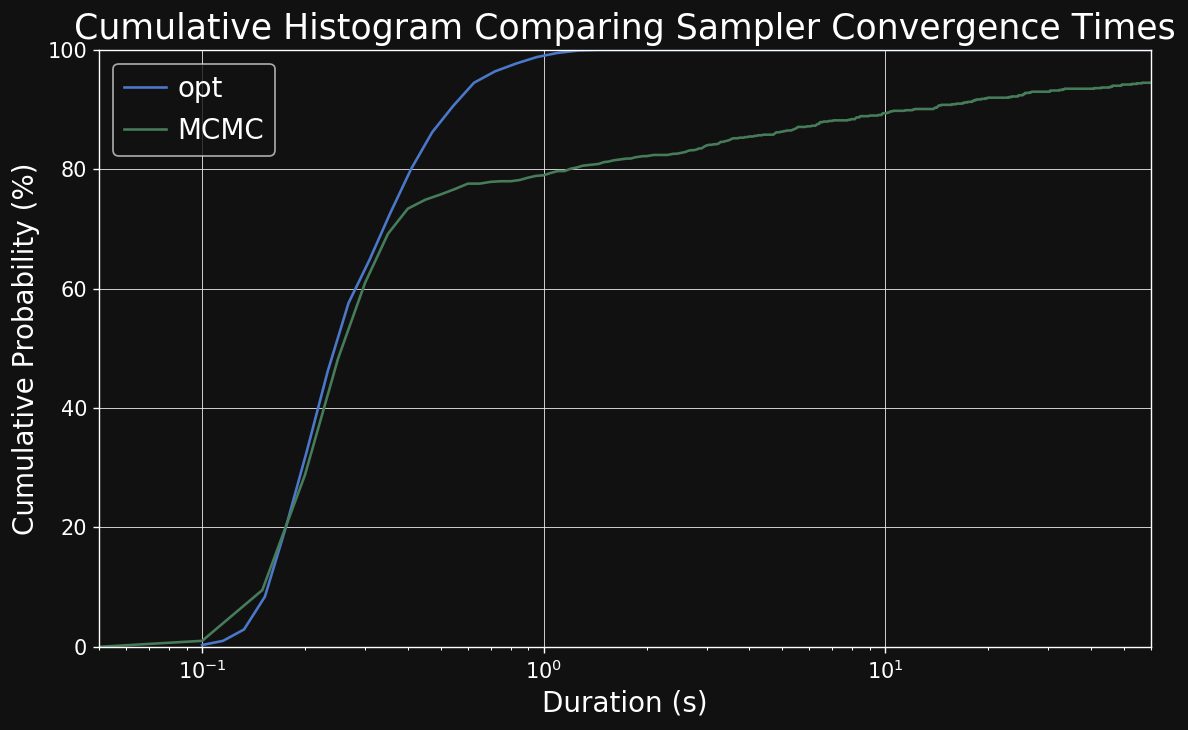

In [6]:
opt_durations = np.logspace(-1, 2)
mcmc_durations = np.arange(time_step_size, 60, time_step_size)

fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
ax.set_xscale('log')
ax.plot(opt_durations, [(results['opt_duration'] <= duration).sum() / results.shape[0] * 100 for duration in opt_durations], label='opt')
ax.plot(mcmc_durations, [(results['MCMC_duration'] <= duration).sum() / results.shape[0] * 100 for duration in mcmc_durations], label='MCMC')
ax.set_xlim(time_step_size, time_limit)
ax.set_ylim(0, 100)
ax.set_xlabel('Duration (s)')
ax.set_ylabel('Cumulative Probability (%)')
ax.legend()
ax.set_title('Cumulative Histogram Comparing Sampler Convergence Times');

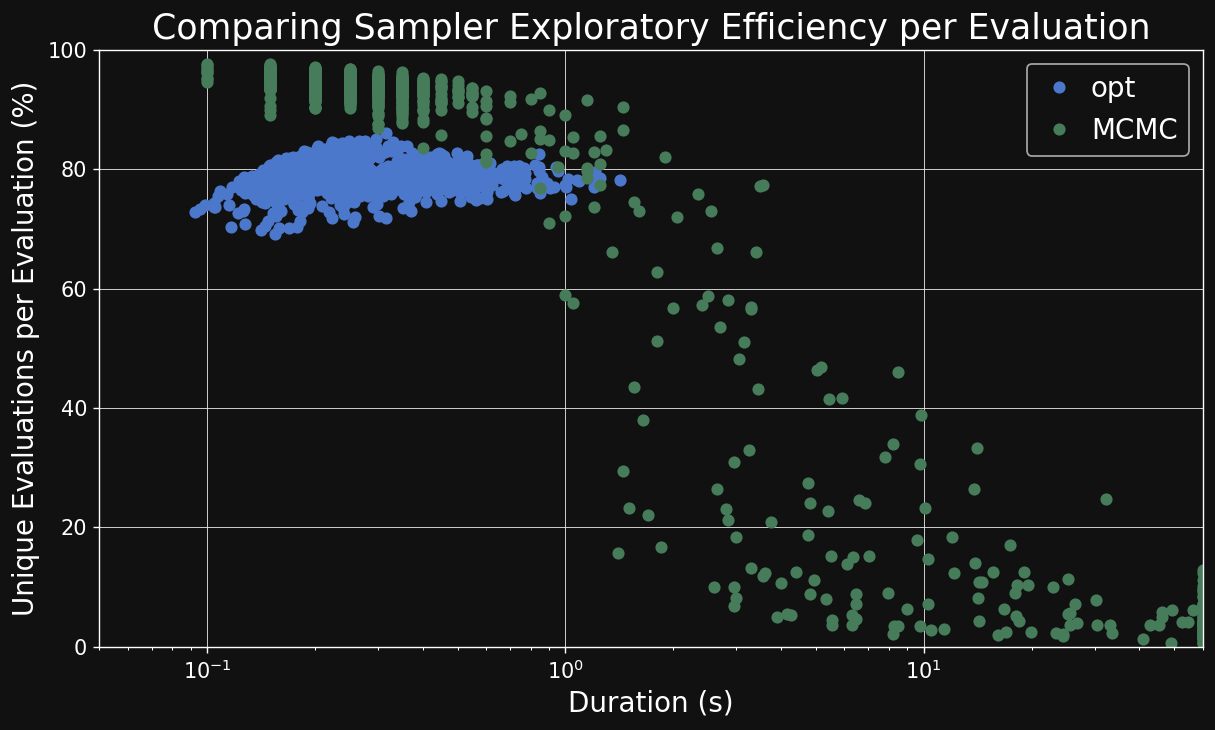

In [7]:
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
ax.set_xscale('log')
ax.plot(results['opt_duration'], results['opt_unique_evals'] / results['opt_evals'] * 100, 'o', label='opt')
ax.plot(results['MCMC_duration'].fillna(time_limit), results['MCMC_unique_evals'] / results['MCMC_evals'] * 100, 'o', label='MCMC')
ax.set_xlabel('Duration (s)')
ax.set_ylabel('Unique Evaluations per Evaluation (%)')
ax.set_xlim(time_step_size, time_limit)
ax.set_ylim(0, 100)
ax.legend()
ax.set_title('Comparing Sampler Exploratory Efficiency per Evaluation');

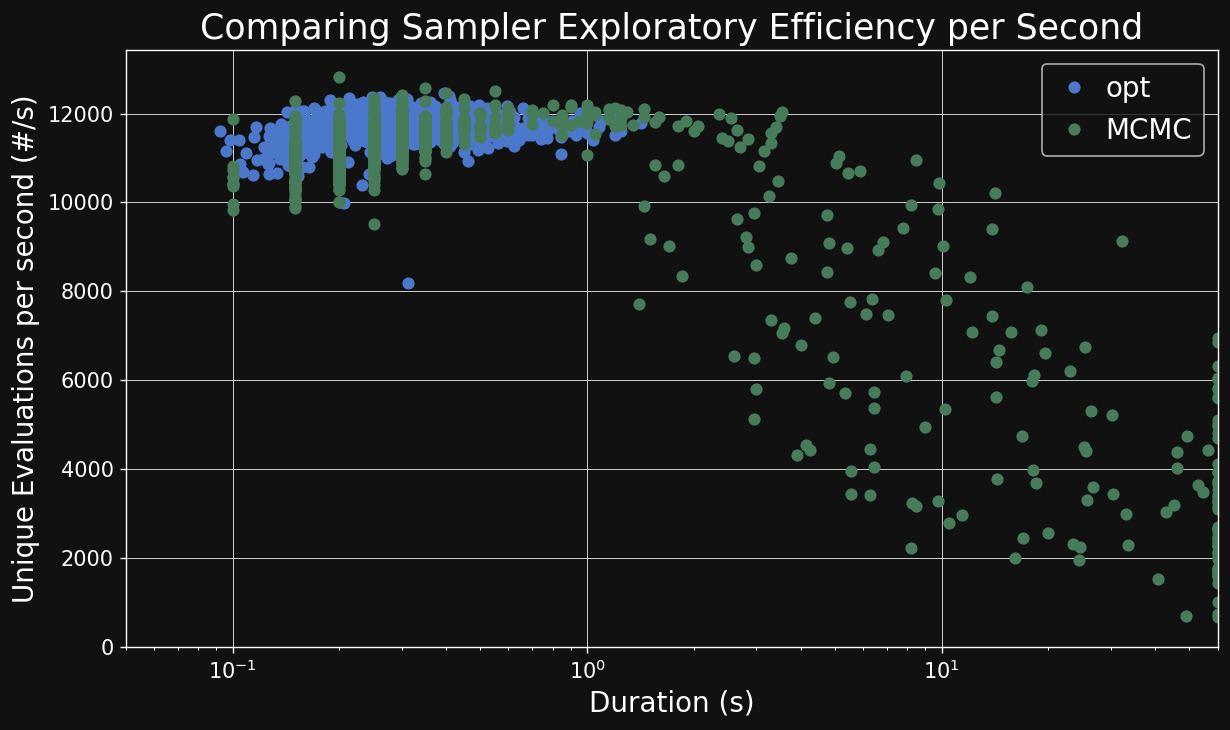

In [8]:
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
ax.set_xscale('log')
ax.plot(results['opt_duration'], results['opt_unique_evals'] / results['opt_duration'], 'o', label='opt')
ax.plot(results['MCMC_duration'].fillna(time_limit), results['MCMC_unique_evals'] / results['MCMC_duration'].fillna(time_limit), 'o', label='MCMC')
ax.set_xlabel('Duration (s)')
ax.set_ylabel('Unique Evaluations per second (#/s)')
ax.set_xlim(time_step_size, time_limit)
ax.set_ylim(0)
ax.legend()
ax.set_title('Comparing Sampler Exploratory Efficiency per Second');